In [2]:
import os
import time
import math
import pickle
from contextlib import nullcontext
import socket
import numpy as np
import torch
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group

from model_tmax import GPTConfig, GPT

import warnings
from typing import Union, Iterable, List, Dict, Tuple, Optional

import torch
from torch import Tensor, inf
from torch.utils._foreach_utils import _group_tensors_by_device_and_dtype, _has_foreach_support

import os
import json
import numpy as np

import os
import json
import numpy as np
import tiktoken
from sklearn.decomposition import PCA

enc = tiktoken.get_encoding("gpt2")

scale_modes = ['all', 'task', 'dp', 'dp_0m']
pca_modes = ['all', 'task']



#for model_name in ['standard']:
#for model_name in ['harmonic']:
for model_name in ['standard', 'harmonic']:

    for scale_mode in scale_modes:
        for pca_mode in pca_modes:

            n_componentss = [2,5,10,100]

            for n_components in n_componentss:

                print(f'model_name={model_name}')
                print(f'scale_mode={scale_mode}')
                print(f'pca_mode={pca_mode}')
                print(f'n components={n_components}')

                #model_name = 'standard' #'harmonic'
                #model_name = 'harmonic'

                ckpt_step = 10000
                ppp = []

                hostname = socket.gethostname()

                print(ckpt_step)
                # -----------------------------------------------------------------------------
                # default config values designed to train a gpt2 (124M) on OpenWebText
                # I/O
                out_dir = 'out'
                eval_interval = 2000
                log_interval = 1
                eval_iters = 200
                eval_only = False # if True, script exits right after the first eval
                always_save_checkpoint = True # if True, always save a checkpoint after each eval
                init_from = 'scratch' # 'scratch' or 'resume' or 'gpt2*'
                # wandb logging
                wandb_log = False # disabled by default
                wandb_project = 'owt'
                wandb_run_name = 'gpt2' # 'run' + str(time.time())
                os.environ["WANDB_MODE"]="offline" # run wandb offline
                # data
                dataset = 'openwebtext'
                gradient_accumulation_steps = 5 # used to simulate larger batch sizes
                batch_size = 12 # if gradient_accumulation_steps > 1, this is the micro-batch size
                block_size = 1024
                # model
                n_layer = 12
                n_head = 12
                n_embd = 768
                dropout = 0.0 # for pretraining 0 is good, for finetuning try 0.1+
                bias = False # do we use bias inside LayerNorm and Linear layers?
                # optimizer
                optimizer_name = 'adamw' 
                learning_rate = 6e-4 # max learning rate
                max_iters = 600000 # total number of training iterations
                weight_decay = 1e-1
                beta1 = 0.9
                beta2 = 0.95
                grad_clip = 1.0 # clip gradients at this value, or disable if == 0.0
                rho = 0.1
                interval = 10
                variant = 4 
                # learning rate decay settings
                decay_lr = True # whether to decay the learning rate
                warmup_iters = 2000 # how many steps to warm up for
                lr_decay_iters = 600000 # should be ~= max_iters per Chinchilla
                min_lr = 6e-5 # minimum learning rate, should be ~= learning_rate/10 per Chinchilla
                # DDP settings
                backend = 'nccl' # 'nccl', 'gloo', etc.
                # system
                device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1' etc., or try 'mps' on macbooks
                dtype = 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
                compile = True # use PyTorch 2.0 to compile the model to be faster
                scale_attn_by_inverse_layer_idx = True
                # -----------------------------------------------------------------------------
                config_keys = [k for k,v in globals().items() if not k.startswith('_') and isinstance(v, (int, float, bool, str))]

                wandb_log = True
                wandb_project = 'anneal'
                wandb_run_name='gpt2-small-weightdecay-0-gradclipvalue-1'

                # these make the total batch size be ~0.5M
                # 8 batch size * 1024 block size * 6 gradaccum * 10 GPUs = 491,520
                batch_size = 8
                block_size = 1024
                gradient_accumulation_steps = 6

                n_layer = 12
                n_head = 12
                n_embd = 768
                dropout = 0.0 # for pretraining 0 is good, for finetuning try 0.1+
                bias = False

                # this makes total number of tokens be 300B
                #max_iters = 100000
                max_iters = 10000
                lr_decay_iters = 10000

                # eval stuff
                eval_interval = 1000
                eval_iters = 200
                log_interval = 10

                # optimizer
                optimizer_name = 'adamw'
                learning_rate = 6e-4 # max learning rate
                weight_decay = 0 #1e-1
                beta1 = 0.9
                beta2 = 0.95
                beta3 = 0.
                gamma = 1.
                lr_max = 6e-4
                grad_clip = 1.0 # clip gradients at this value, or disable if == 0.0
                # learning rate decay settings
                decay_lr = True # whether to decay the learning rate
                warmup_iters = 2000 # how many steps to warm up for
                #warmup_iters = 0 # how many steps to warm up for
                min_lr = 3e-5 

                compile = True

                if model_name == 'standard':
                    out_dir = 'out_small_adam'
                if model_name == 'harmonic':
                    out_dir = 'out_small_adam_hm'

                #out_dir = 'out_small_n_28_scale_28_6e-3_3e-4'
                device = 'cpu'

                config = {k: globals()[k] for k in config_keys} # will be useful for logging
                # -----------------------------------------------------------------------------

                # various inits, derived attributes, I/O setup
                ddp = int(os.environ.get('RANK', -1)) != -1 # is this a ddp run?
                if ddp:
                    init_process_group(backend=backend)
                    ddp_rank = int(os.environ['RANK'])
                    ddp_local_rank = int(os.environ['LOCAL_RANK'])
                    world_size = int(os.environ["WORLD_SIZE"])
                    torch.cuda.set_device(ddp_local_rank)
                    print(f"Rank {ddp_rank}: world_size={world_size}, local_rank={ddp_local_rank}, hostname={hostname}")
                    master_process = ddp_rank == 0 # this process will do logging, checkpointing etc.
                    seed_offset = ddp_rank # each process gets a different seed
                    device = torch.device("cuda", ddp_local_rank)
                else:
                    # if not ddp, we are running on a single gpu, and one process
                    master_process = True
                    seed_offset = 0
                    gradient_accumulation_steps *= 8 # simulate 8 gpus

                if master_process:
                    os.makedirs(out_dir, exist_ok=True)
                torch.manual_seed(5000 + seed_offset)
                torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
                torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
                #device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
                device_type = 'cuda'
                # note: float16 data type will automatically use a GradScaler
                ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
                ctx = nullcontext() if device_type == 'cpu' else torch.autocast(device_type=device_type, dtype=ptdtype)

                # poor man's data loader
                #data_dir = os.path.join('data', dataset)
                data_dir = os.path.join('./')
                #data_dir = './data'
                train_data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
                val_data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r')
                def get_batch(split):
                    data = train_data if split == 'train' else val_data
                    ix = torch.randint(len(data) - block_size, (batch_size,))
                    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
                    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
                    if device_type == 'cuda':
                        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
                        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
                    else:
                        x, y = x.to(device), y.to(device)
                    return x, y

                # init these up here, can override if init_from='resume' (i.e. from a checkpoint)
                iter_num = 0
                best_val_loss = 1e9

                # attempt to derive vocab_size from the dataset
                meta_path = os.path.join(data_dir, 'meta.pkl')
                meta_vocab_size = None
                if os.path.exists(meta_path):
                    with open(meta_path, 'rb') as f:
                        meta = pickle.load(f)
                    meta_vocab_size = meta['vocab_size']
                    print(f"found vocab_size = {meta_vocab_size} (inside {meta_path})")

                # model init
                model_args = dict(n_layer=n_layer, n_head=n_head, n_embd=n_embd, block_size=block_size,
                                  bias=bias, vocab_size=None, dropout=dropout, scale_attn_by_inverse_layer_idx=scale_attn_by_inverse_layer_idx) # start with model_args from command line


                print(f"Resuming training from {out_dir}")
                # resume training from a checkpoint.
                ckpt_path = os.path.join(out_dir, f'ckpt_{ckpt_step}.pt')
                checkpoint = torch.load(ckpt_path, map_location=device)
                checkpoint_model_args = checkpoint['model_args']
                # force these config attributes to be equal otherwise we can't even resume training
                # the rest of the attributes (e.g. dropout) can stay as desired from command line
                for k in ['n_layer', 'n_head', 'n_embd', 'block_size', 'bias', 'vocab_size']:
                    model_args[k] = checkpoint_model_args[k]
                # create the model
                gptconf = GPTConfig(**model_args)
                model = GPT(gptconf)
                state_dict = checkpoint['model']
                # fix the keys of the state dictionary :(
                # honestly no idea how checkpoints sometimes get this prefix, have to debug more
                unwanted_prefix = '_orig_mod.'
                for k,v in list(state_dict.items()):
                    if k.startswith(unwanted_prefix):
                        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
                model.load_state_dict(state_dict)
                iter_num = checkpoint['iter_num']
                best_val_loss = checkpoint['best_val_loss']

                def listdir_nohidden(path):
                    for f in os.listdir(path):
                        if not f.startswith('.'):
                            yield f

                arr = list(listdir_nohidden('./abstractive'))

                scoress = []

                for file in arr:  

                    print(file)
                    #if file == 'singular-plural.json'

                    seed = 0
                    np.random.seed(seed)

                    with open(f'./abstractive/{file}', 'r') as f:
                        data = json.load(f)

                    p = len(data)

                    n_train = 10000

                    id1 = np.random.choice(p, n_train)
                    id_diff = np.random.choice(p-1, n_train) + 1
                    id2 = (id1 + id_diff) % p


                    wordss = []

                    for i in range(n_train):
                        wordss.append([data[id1[i]]['input'],data[id1[i]]['output'], data[id2[i]]['input'],data[id2[i]]['output']])


                    embd_model = model.transformer.wte.weight.detach().numpy()
                    embd_model = embd_model - np.mean(embd_model, axis=0)[None,:]


                    embds_task = []
                    for words in wordss:
                        for i in range(4):
                            true_content = words[i]
                            idx = enc.encode(true_content)
                            embds_task.append(embd_model[idx[-1]])

                    embds_task = np.array(embds_task)


                    pca = PCA(n_components=n_components)

                    if pca_mode == 'all':
                        embd_model_pca = pca.fit_transform(embd_model)
                    elif pca_mode == 'task':
                        pca.fit(embds_task)
                        embd_model_pca = pca.transform(embd_model)

                    
                    if scale_mode == 'all':
                        scale = np.mean(embd_model_pca**2) * n_components
                    elif scale_mode == 'task':
                        embds_task = []
                        for words in wordss:
                            for i in range(4):
                                true_content = words[i]
                                idx = enc.encode(true_content)
                                embds_task.append(embd_model_pca[idx[-1]])

                        embds_task = np.array(embds_task)
                        scale = np.mean(embds_task**2) * n_components

                    

                    scores = []

                    for words in wordss:
                        embds = []

                        for i in range(4):
                            true_content = words[i]
                            idx = enc.encode(true_content)
                            embds.append(embd_model_pca[idx[-1]])

                        embds = np.array(embds)
                        
                        if scale_mode == 'dp':
                            scale = np.mean(embds**2)
                            
                        elif scale_mode == 'dp_0m':
                            embds -= np.mean(embds, axis=0)[None, :]
                            scale = np.mean(embds**2)
                        
                        score = np.linalg.norm(embds[0] + embds[3] - (embds[1] + embds[2]))**2/scale
                        scores.append(score)

                    scoress.append(scores)

                    if model_name == 'harmonic':
                        np.save(f'./results/fv_hm_{n_components}pc_pca_{pca_mode}_scale_{scale_mode}', np.array(scoress))
                    if model_name == 'standard':
                        np.save(f'./results/fv_ce_{n_components}pc_pca_{pca_mode}_scale_{scale_mode}', np.array(scoress))

model_name=standard
scale_mode=all
pca_mode=all
n components=2
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=standard
scale_mode=all
pca_mode=all
n components=5
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=standard
scale_mode=all
pca_mode=all
n components=10
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=standard
scale_mode=all
pca_mode=all
n components=100
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=standard
scale_mode=all
pca_mode=task
n components=2
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=standard
scale_mode=all
pca_mode=task
n components=5
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=standard
scale_mode=all
pca_mode=task
n components=10
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=standard
scale_mode=all
pca_mode=task
n components=100
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=standard
scale_mode=task
pca_mode=all
n components=2
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=standard
scale_mode=task
pca_mode=all
n components=5
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=standard
scale_mode=task
pca_mode=all
n components=10
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=standard
scale_mode=task
pca_mode=all
n components=100
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=standard
scale_mode=task
pca_mode=task
n components=2
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=standard
scale_mode=task
pca_mode=task
n components=5
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=standard
scale_mode=task
pca_mode=task
n components=10
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=standard
scale_mode=task
pca_mode=task
n components=100
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=standard
scale_mode=dp
pca_mode=all
n components=2
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=standard
scale_mode=dp
pca_mode=all
n components=5
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=standard
scale_mode=dp
pca_mode=all
n components=10
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=standard
scale_mode=dp
pca_mode=all
n components=100
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=standard
scale_mode=dp
pca_mode=task
n components=2
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=standard
scale_mode=dp
pca_mode=task
n components=5
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=standard
scale_mode=dp
pca_mode=task
n components=10
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=standard
scale_mode=dp
pca_mode=task
n components=100
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=standard
scale_mode=dp_0m
pca_mode=all
n components=2
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_52550/1434473628.py:350: RuntimeWarning: invalid value encountered in scalar divide
  score = np.linalg.norm(embds[0] + embds[3] - (embds[1] + embds[2]))**2/scale


prev_item.json
capitalize.json


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_52550/1434473628.py:350: RuntimeWarning: invalid value encountered in scalar divide
  score = np.linalg.norm(embds[0] + embds[3] - (embds[1] + embds[2]))**2/scale


english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=standard
scale_mode=dp_0m
pca_mode=all
n components=5
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_52550/1434473628.py:350: RuntimeWarning: invalid value encountered in scalar divide
  score = np.linalg.norm(embds[0] + embds[3] - (embds[1] + embds[2]))**2/scale


prev_item.json
capitalize.json


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_52550/1434473628.py:350: RuntimeWarning: invalid value encountered in scalar divide
  score = np.linalg.norm(embds[0] + embds[3] - (embds[1] + embds[2]))**2/scale


english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=standard
scale_mode=dp_0m
pca_mode=all
n components=10
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_52550/1434473628.py:350: RuntimeWarning: invalid value encountered in scalar divide
  score = np.linalg.norm(embds[0] + embds[3] - (embds[1] + embds[2]))**2/scale


prev_item.json
capitalize.json


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_52550/1434473628.py:350: RuntimeWarning: invalid value encountered in scalar divide
  score = np.linalg.norm(embds[0] + embds[3] - (embds[1] + embds[2]))**2/scale


english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=standard
scale_mode=dp_0m
pca_mode=all
n components=100
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_52550/1434473628.py:350: RuntimeWarning: invalid value encountered in scalar divide
  score = np.linalg.norm(embds[0] + embds[3] - (embds[1] + embds[2]))**2/scale


prev_item.json
capitalize.json


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_52550/1434473628.py:350: RuntimeWarning: invalid value encountered in scalar divide
  score = np.linalg.norm(embds[0] + embds[3] - (embds[1] + embds[2]))**2/scale


english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=standard
scale_mode=dp_0m
pca_mode=task
n components=2
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_52550/1434473628.py:350: RuntimeWarning: invalid value encountered in scalar divide
  score = np.linalg.norm(embds[0] + embds[3] - (embds[1] + embds[2]))**2/scale


prev_item.json
capitalize.json


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_52550/1434473628.py:350: RuntimeWarning: invalid value encountered in scalar divide
  score = np.linalg.norm(embds[0] + embds[3] - (embds[1] + embds[2]))**2/scale


english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=standard
scale_mode=dp_0m
pca_mode=task
n components=5
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_52550/1434473628.py:350: RuntimeWarning: invalid value encountered in scalar divide
  score = np.linalg.norm(embds[0] + embds[3] - (embds[1] + embds[2]))**2/scale


prev_item.json
capitalize.json


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_52550/1434473628.py:350: RuntimeWarning: invalid value encountered in scalar divide
  score = np.linalg.norm(embds[0] + embds[3] - (embds[1] + embds[2]))**2/scale


english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=standard
scale_mode=dp_0m
pca_mode=task
n components=10
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_52550/1434473628.py:350: RuntimeWarning: invalid value encountered in scalar divide
  score = np.linalg.norm(embds[0] + embds[3] - (embds[1] + embds[2]))**2/scale


prev_item.json
capitalize.json


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_52550/1434473628.py:350: RuntimeWarning: invalid value encountered in scalar divide
  score = np.linalg.norm(embds[0] + embds[3] - (embds[1] + embds[2]))**2/scale


english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=standard
scale_mode=dp_0m
pca_mode=task
n components=100
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_52550/1434473628.py:350: RuntimeWarning: invalid value encountered in scalar divide
  score = np.linalg.norm(embds[0] + embds[3] - (embds[1] + embds[2]))**2/scale


prev_item.json
capitalize.json


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_52550/1434473628.py:350: RuntimeWarning: invalid value encountered in scalar divide
  score = np.linalg.norm(embds[0] + embds[3] - (embds[1] + embds[2]))**2/scale


english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=harmonic
scale_mode=all
pca_mode=all
n components=2
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=harmonic
scale_mode=all
pca_mode=all
n components=5
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=harmonic
scale_mode=all
pca_mode=all
n components=10
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=harmonic
scale_mode=all
pca_mode=all
n components=100
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=harmonic
scale_mode=all
pca_mode=task
n components=2
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=harmonic
scale_mode=all
pca_mode=task
n components=5
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=harmonic
scale_mode=all
pca_mode=task
n components=10
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=harmonic
scale_mode=all
pca_mode=task
n components=100
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=harmonic
scale_mode=task
pca_mode=all
n components=2
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=harmonic
scale_mode=task
pca_mode=all
n components=5
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=harmonic
scale_mode=task
pca_mode=all
n components=10
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=harmonic
scale_mode=task
pca_mode=all
n components=100
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=harmonic
scale_mode=task
pca_mode=task
n components=2
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=harmonic
scale_mode=task
pca_mode=task
n components=5
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=harmonic
scale_mode=task
pca_mode=task
n components=10
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=harmonic
scale_mode=task
pca_mode=task
n components=100
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=harmonic
scale_mode=dp
pca_mode=all
n components=2
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=harmonic
scale_mode=dp
pca_mode=all
n components=5
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=harmonic
scale_mode=dp
pca_mode=all
n components=10
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=harmonic
scale_mode=dp
pca_mode=all
n components=100
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=harmonic
scale_mode=dp
pca_mode=task
n components=2
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=harmonic
scale_mode=dp
pca_mode=task
n components=5
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=harmonic
scale_mode=dp
pca_mode=task
n components=10
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=harmonic
scale_mode=dp
pca_mode=task
n components=100
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json
prev_item.json
capitalize.json
english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=harmonic
scale_mode=dp_0m
pca_mode=all
n components=2
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_52550/1434473628.py:350: RuntimeWarning: invalid value encountered in scalar divide
  score = np.linalg.norm(embds[0] + embds[3] - (embds[1] + embds[2]))**2/scale


prev_item.json
capitalize.json


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_52550/1434473628.py:350: RuntimeWarning: invalid value encountered in scalar divide
  score = np.linalg.norm(embds[0] + embds[3] - (embds[1] + embds[2]))**2/scale


english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=harmonic
scale_mode=dp_0m
pca_mode=all
n components=5
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_52550/1434473628.py:350: RuntimeWarning: invalid value encountered in scalar divide
  score = np.linalg.norm(embds[0] + embds[3] - (embds[1] + embds[2]))**2/scale


prev_item.json
capitalize.json


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_52550/1434473628.py:350: RuntimeWarning: invalid value encountered in scalar divide
  score = np.linalg.norm(embds[0] + embds[3] - (embds[1] + embds[2]))**2/scale


english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=harmonic
scale_mode=dp_0m
pca_mode=all
n components=10
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_52550/1434473628.py:350: RuntimeWarning: invalid value encountered in scalar divide
  score = np.linalg.norm(embds[0] + embds[3] - (embds[1] + embds[2]))**2/scale


prev_item.json
capitalize.json


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_52550/1434473628.py:350: RuntimeWarning: invalid value encountered in scalar divide
  score = np.linalg.norm(embds[0] + embds[3] - (embds[1] + embds[2]))**2/scale


english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=harmonic
scale_mode=dp_0m
pca_mode=all
n components=100
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_52550/1434473628.py:350: RuntimeWarning: invalid value encountered in scalar divide
  score = np.linalg.norm(embds[0] + embds[3] - (embds[1] + embds[2]))**2/scale


prev_item.json
capitalize.json


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_52550/1434473628.py:350: RuntimeWarning: invalid value encountered in scalar divide
  score = np.linalg.norm(embds[0] + embds[3] - (embds[1] + embds[2]))**2/scale


english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=harmonic
scale_mode=dp_0m
pca_mode=task
n components=2
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_52550/1434473628.py:350: RuntimeWarning: invalid value encountered in scalar divide
  score = np.linalg.norm(embds[0] + embds[3] - (embds[1] + embds[2]))**2/scale


prev_item.json
capitalize.json


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_52550/1434473628.py:350: RuntimeWarning: invalid value encountered in scalar divide
  score = np.linalg.norm(embds[0] + embds[3] - (embds[1] + embds[2]))**2/scale


english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=harmonic
scale_mode=dp_0m
pca_mode=task
n components=5
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_52550/1434473628.py:350: RuntimeWarning: invalid value encountered in scalar divide
  score = np.linalg.norm(embds[0] + embds[3] - (embds[1] + embds[2]))**2/scale


prev_item.json
capitalize.json


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_52550/1434473628.py:350: RuntimeWarning: invalid value encountered in scalar divide
  score = np.linalg.norm(embds[0] + embds[3] - (embds[1] + embds[2]))**2/scale


english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=harmonic
scale_mode=dp_0m
pca_mode=task
n components=10
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_52550/1434473628.py:350: RuntimeWarning: invalid value encountered in scalar divide
  score = np.linalg.norm(embds[0] + embds[3] - (embds[1] + embds[2]))**2/scale


prev_item.json
capitalize.json


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_52550/1434473628.py:350: RuntimeWarning: invalid value encountered in scalar divide
  score = np.linalg.norm(embds[0] + embds[3] - (embds[1] + embds[2]))**2/scale


english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json
model_name=harmonic
scale_mode=dp_0m
pca_mode=task
n components=100
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
antonym.json


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_52550/1434473628.py:350: RuntimeWarning: invalid value encountered in scalar divide
  score = np.linalg.norm(embds[0] + embds[3] - (embds[1] + embds[2]))**2/scale


prev_item.json
capitalize.json


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_52550/1434473628.py:350: RuntimeWarning: invalid value encountered in scalar divide
  score = np.linalg.norm(embds[0] + embds[3] - (embds[1] + embds[2]))**2/scale


english-german.json
word_length.json
country-capital.json
synonym.json
next_item.json
english-french.json
singular-plural.json
english-spanish.json
present-past.json


In [23]:
n_components = 2
pca_mode = 'all'
scale_mode = 'all'

#scale_modes = ['all', 'task', 'dp', 'dp_0m']
#pca_modes = ['all', 'task']


ce = np.load(f'./results/fv_ce_{n_components}pc_pca_{pca_mode}_scale_{scale_mode}.npy')
hm = np.load(f'./results/fv_hm_{n_components}pc_pca_{pca_mode}_scale_{scale_mode}.npy')

Text(0.5, 1.02, 'parallelogram loss (2 PC)')

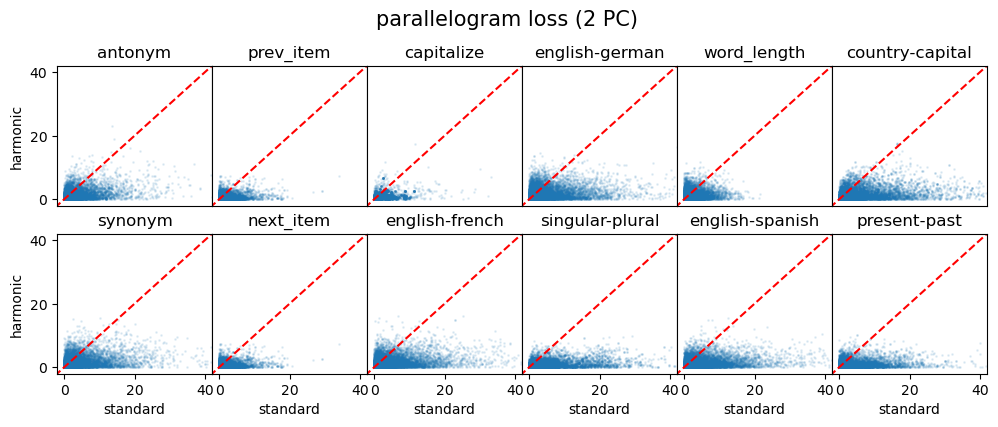

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

for i in range(12):
    plt.subplot(2,6,i+1)
    
    plt.scatter(ce[i], hm[i], s=1, alpha=0.1)
    plt.plot([-5,50],[-5,50], ls='--', color='red')
    plt.xlim(-2,42)
    plt.ylim(-2,42)
    if i < 6:
        plt.xticks([])
    else:
        plt.xticks([0,20,40])
    if i > 5:
        plt.xlabel('standard')
    if i == 0 or i == 6:
        plt.ylabel('harmonic')
        plt.yticks([0,20,40])
    else:
        plt.yticks([])
    plt.title(arr[i][:-5])
    
    
plt.subplots_adjust(wspace=0.0, hspace=0.2)

plt.suptitle(f'parallelogram loss ({n_components} PC)', fontsize=15, y=1.02)
#plt.savefig(f'./gpt2_ploss_scatter_{n_components}pc.png', bbox_inches='tight', dpi=200)

Text(0.5, 1.02, 'accumulated fractions (2 PC)')

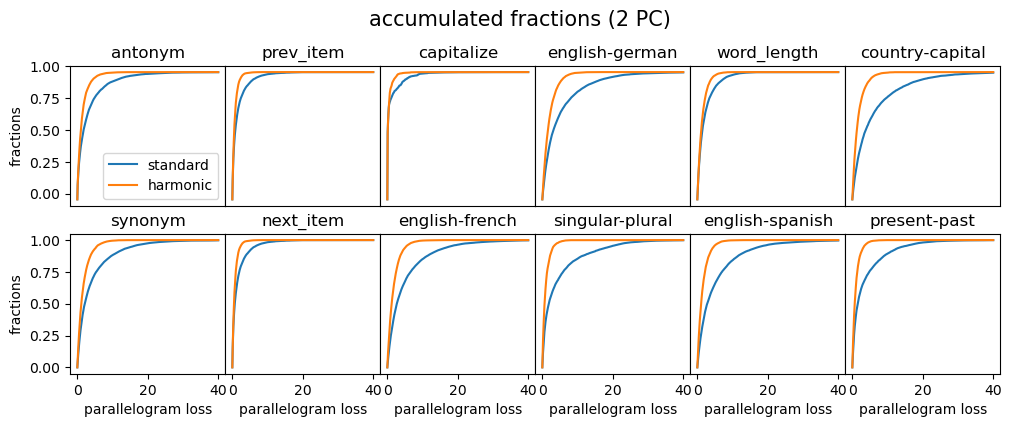

In [25]:
plt.figure(figsize=(12,4))

for i in range(12):
    plt.subplot(2,6,i+1)
    
    thresholds = np.linspace(0,40,num=401)
    ces = []
    hms = []
    i_task = i
    ce_base = np.sum(ce[i_task] == 0)
    hm_base = np.sum(hm[i_task] == 0)

    for threshold in thresholds:
        ces.append(np.sum(ce[i_task] < threshold)-ce_base)
        hms.append(np.sum(hm[i_task] < threshold)-hm_base)

    plt.plot(thresholds, np.array(ces)/n_train)
    plt.plot(thresholds, np.array(hms)/n_train)
    
    if i >= 6:
        plt.xlabel('parallelogram loss')
    if i == 0 or i == 6:
        plt.ylabel('fractions')
    else:
        plt.yticks([])
    if i == 0:
        plt.legend(['standard', 'harmonic'])
    if i < 6:
        plt.xticks([])
        
    #plt.xscale('log')
        
    plt.title(arr[i][:-5])
plt.subplots_adjust(wspace=0.0, hspace=0.2)
plt.suptitle(f'accumulated fractions ({n_components} PC)', fontsize=15, y=1.02)
#plt.savefig(f'./gpt2_fraction_{n_components}pc.png', bbox_inches='tight', dpi=200)